<a href="https://colab.research.google.com/github/Prot10/ADM_HW_3/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Homework 3 - Places of the world__

Travelling is a pleasant activity which has increased since the end of the COVID-19 pandemic. Nowadays, people look for places to visit which are attractive, affordable, with a rich history and which have recommended activities. Using user-generated content, [Atlas Obscura](https://www.atlasobscura.com), an American online magazine and travel firm, catalogues unusual and obscure tourist locations. The website's articles span many subjects, including history, science, cuisine, and unique places.

You and your team have been hired to provide your Data Science knowledge to create a search engine which will facilitate specific searches towards a topic related to the most popular places to visit. Important: All the functions must be implemented from scratch unless differently specified.

Then, let's get started!

In [ ]:
pip install geocoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 98 kB 3.8 MB/s 


In [ ]:
pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import lxml
import requests
import urllib.request 
import os
import json
import re
import codecs
import pandas as pd
import numpy as np
import time
import csv
import pickle
import nltk
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import datetime
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
nltk.download('stopwords')
nltk.download('punkt')
import geocoder
import haversine as hs
import heapq
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


## 1. Data collection

For this homework, there is no provided dataset. Instead, you have to build your own. Your search engine will run on text documents. So, here we detail the procedure to follow for the data collection.

### 1.1. Get the list of places
We start with the list of places to include in your corpus of documents. In particular, we focus on the [Most popular places](https://www.atlasobscura.com/places?sort=likes_count). Next, we want you to __collect the URL__ associated with each site in the list from this list. The list is long and split into many pages. Therefore, we ask you to retrieve only the URLs of the places listed in the __first 400 pages__ (each page has 18 places, so that you will end up with 7200 unique place URLs).

The output of this step is a `.txt` file whose single line corresponds to the place's URL.

In [ ]:
# create a text file
LinkFiles = open("/content/drive/MyDrive/ADM_HW_3/places_lists.txt", "w")
# save the URL assiociated to the places in the first 400 pages
for i in tqdm(range(1, 401)):
    url = 'https://www.atlasobscura.com/places?page=' +str(i)+'&sort=likes_count' 

    response = requests.get(url)
    soup = BeautifulSoup(response.content, features='lxml')
    for a in soup.find_all('a', class_="content-card content-card-place"):
        LinkFiles.write(a.get('href')+'\n')

LinkFiles.close()

### 1.2. Crawl places

Once you get all the URLs in the first 400 pages of the list, you:

1. Download the `HTML` corresponding to each of the collected URLs.

2. After you collect a single page, immediately save its `HTML` in a file. In this way, if your program stops for any reason, you will not lose the data collected up to the stopping point.

3. Organize the entire set of downloaded `HTML` pages into folders. Each folder will contain the `HTML` of the places on page 1, page 2, ... of the list of locations.

__Tip:__ Due to a large number of pages you should download, you can use some methods that can help you shorten the time it takes. If you employed a particular process or approach, kindly describe it.

In [ ]:
#creating a subfolder to store the html file of the page 'page'
for page in tqdm(range(1,401)):
    subfolder = "/content/drive/MyDrive/ADM_HW_3/html_page/page_{}".format(page)
    os.makedirs(subfolder)

    f = open("/content/drive/MyDrive/ADM_HW_3/places_lists.txt", 'r', encoding="utf8")
    lines = f.readlines()[(page-1)*18:(page)*18]
    lines = [line.rstrip() for line in lines]
    f.close

    i = 1+18*(page-1)
    #for each link that we read let's create a new .html file
    for link in lines:
        link = ' https://www.atlasobscura.com' + link
        html = requests.get(link)
    
        
        file_name = '{}/{}.html'.format(subfolder, i)
        g = open(file_name, 'w', encoding="utf8")
        g.write(html.text)
        g.close
        i += 1

### 1.3 Parse downloaded pages

At this point, you should have all the HTML documents about the places of interest, and you can start to extract the places' information. The list of the information we desire for each place and their format is as follows:

1. Place Name (to save as `placeName`): String.
2. Place Tags (to save as `placeTags`): List of Strings.
3. \# of people who have been there (to save as `numPeopleVisited`): Integer.
4. \# of people who want to visit the place(to save as `numPeopleWant`): Integer.
5. Description (to save as `placeDesc`): String. Everything from under the first image up to "know before you go" (orange frame on the example image).
6. Short Description (to save as `placeShortDesc`): String. Everything from the title and location up to the image (blue frame on the example image).
7. Nearby Places (to save as `placeNearby`): Extract the names of all nearby places, but only keep unique values: List of Strings.
8. Address of the place(to save as `placeAddress`): String.
9. Latitud and Longitude of the place's location(to save as `placeAlt` and `placeLong`): Floats
10. The username of the post editors (to save as `placeEditors`): List of Strings.
11. Post publishing date (to save as `placePubDate`): datetime.
12. The names of the lists that the place was included in (to save as `placeRelatedLists`): List of Strings.
13. The names of the related places (to save as `placeRelatedPlaces`): List of Strings.
14. The URL of the page of the place (to save as `placeURL`): String

In [ ]:
pages = sorted(os.listdir('/content/drive/MyDrive/ADM_HW_3/html_page')[1:], key = lambda x : int(x.split("_")[1]))
placeName = []
placeTags = []
numPeopleVisited = []
numPeopleWant = []
placeDesc = []
placeShortDesc = []
placeNearby = []
placeAddress = []
placeAlt = []
placeLong = []
placeEditors = []
placePubDate = []
placeRelatedLists = []
placeRelatedPlaces = []
placeURL = []

In [ ]:
for i in pages:
    htmls = os.listdir('/content/drive/MyDrive/ADM_HW_3/html_page'+"/"+str(i))
    for j in range(1,1+len(htmls)):
        file = open("/content/drive/MyDrive/ADM_HW_3/html_page/{}/{}.html".format(i,18*(int(i.split("_")[1])-1)+j), 'r', encoding="utf8")
        place = BeautifulSoup(file, 'lxml')
        
       #title
        try:
            t=place.find('meta', attrs = {'property':'og:title'})
            t=t['content']
            placeName.append(t)
        except:
            placeName.append('')

        #description
        try:
            d=place.find("div", class_ = 'DDP__body-copy').text.strip()
            placeDesc.append(d)
        except:
            placeDesc.append('')

        #shortdescription
        try:
            sd=place.find('meta', attrs = {'property':'og:description'})
            sd=sd['content']
            placeShortDesc.append(sd)
        except:
            placeShortDesc.append('')

      #pubdate
        try:
            pdate=place.find('div', class_ = 'DDPContributor__name').text.strip()
            placePubDate.append(pdate)
        except:
            placePubDate.append('')

        #placealt
        try:
            pa=place.find('meta', attrs = {'property':'place:location:latitude'})
            pa=pa['content']
            placeAlt.append(pa)
        except:
            placeAlt.append('')
            
        #placelong
        try:
            pl=place.find('meta', attrs = {'property':'place:location:longitude'})
            pl=pl['content']
            placeLong.append(pl)
        except:
            placeLong.append('')            
        #placeTags
        try:
            pt=place.find_all('a', {'class': 'itemTags__link js-item-tags-link'})
            pt=[i.get('href').split('/categories/')[1] for i in pt]
            placeTags.append(pt)
        except:
            placeTags.append('')     

        #numPeopleVisited
        try:
            num_visitors = place.find_all('div', class_ = 'title-md item-action-count')[0].text.strip()
            numPeopleVisited.append(num_visitors)
        except:
            numPeopleVisited.append('')
            
        # num peolpe want
        try:
            num_want = place.find_all('div', class_ = 'title-md item-action-count')[1].text.strip()
            numPeopleWant.append(num_want)
        except:
            numPeopleWant.append('')
         
        #placeNearby
        try:
            pnb=place.find_all('div', {'class':'DDPageSiderailRecirc__item-title'})
            pnb=[i.get_text() for i in pnb]   
            placeNearby.append(pnb)
        except:
            placeNearby.append('')

        #placeAddress
        try:
            pa=place.find_all('address', {'class':'DDPageSiderail__address'})[0]
            pa=pa.find('div').get_text(separator = ' ').split('\n')[0]
            placeAddress.append(pa)
        except:
            placeAddress.append('')

        #placeEditors
        try:
            pe=place.find_all('div', {'class': 'ugc-editor-icons'})
            pe=[i.findChildren('a')[0].get('href') for i in pe]
            pe=[j.split('/users/')[1] for j in pe]
            placeEditors.append(pe)
        except:
            placeEditors.append('')

        #placeRelatedLists
        try:
            prl=place.find_all('div', {"data-gtm-template" : "DDP Footer Recirc Lists"})[0]
            prl=[i.text.strip() for i in prl.find_all('h3')]
            placeRelatedLists.append(prl)
        except:
            placeRelatedLists.append('')

        #placeRelatedPlaces
        try:
            prp=place.find_all('div', {'class':'CardRecircSection__title'})
            prp=[i for i in prp if i.text == 'Related Places'][0]
            prp=prp.find_all_next('div', {'class':'Card__action-btns vue-js-been-there-everywhere-place'})
            prp=[j.get('data-place-title') for j in prp]
            placeRelatedPlaces.append(prp)
        except:
            placeRelatedPlaces.append('')

        #url
        try:
            u=place.find('meta', attrs = {'property':'og:url'})
            u=u['content']
            placeURL.append(u)
        except:
            placeURL.append('')

In [ ]:
col = ['placeName','placeTags','numPeopleVisited','numPeopleWant','placeDesc','placeShortDesc','placeNearby','placeAddress',
       'placeAlt','placeLong','placeEditors','placePubDate','placeRelatedLists','placeRelatedPlaces','placeURL']
types = {'placeName' : 'object',
         'placeTags' : 'object',
         'numPeopleVisited' : 'object',
         'numPeopleWant' : 'object',
         'placeDesc' : 'object',
         'placeShortDesc' : 'object',
         'placeNearby' : 'object',
         'placeAddress' : 'object',
         'placeAlt' : 'int64',
         'placeLong' : 'int64',
         'placeEditors' : 'object',
         'placePubDate' : 'datetime64',
         'placeRelatedLists' : 'object',
         'placeRelatedPlaces' : 'object',
         'placeURL' : 'object'}
data = pd.DataFrame(columns = col).astype(dtype = types) 
data.placeName = placeName 
data.placeTags = placeTags
data.numPeopleVisited = numPeopleVisited
data.numPeopleWant = numPeopleWant
data.placeDesc = placeDesc 
data.placeShortDesc = placeShortDesc 
data.placePubDate = placePubDate
data.placeNearby = placeNearby
data.placeAddress = placeAddress
data.placeAlt = placeAlt
data.placeLong = placeLong
data.placeEditors = placeEditors
data.placePubDate = placePubDate
data.placeRelatedLists = placeRelatedLists
data.placeRelatedPlaces = placeRelatedPlaces
data.placeURL = placeURL 

In [ ]:
# save the data in a single tsv file
data = data.to_csv("/content/drive/MyDrive/ADM_HW_3/places.tsv", sep='\t', index=False)

In [ ]:
# read the first lines of the csv file 
data = pd.read_csv("/content/drive/MyDrive/ADM_HW_3/places.tsv", sep='\t')
data.head()

,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAddress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedLists,placeRelatedPlaces,placeURL
0,City Hall Station,"['subways', 'subterranean', 'infrastructure', ...",1828.0,8579.0,The first New York City subway was built and o...,A beautiful and abandoned New York subway stat...,"['African Burial Ground National Monument', 'T...","31 Centre St New York, New York, 10007 United ...",40.713400,-74.004600,"['rebekah-otto', 'annetta-black']","May 8, 2010",['30 Unexpected Places to Have a Joyful Advent...,"['Crystal Palace Subway', 'Moscow Metro Statio...",http://www.atlasobscura.com/places/city-hall-s...
1,Highgate Cemetery,"['rivals-week', 'vampires', 'hoaxes', 'occult'...",2617.0,8182.0,"Opened in 1839, Highgate is one of London’s mo...",London's creepiest cemetery was once the site ...,"[""World's Largest Potted Plant"", 'Dick Whittin...","Swain's Lane, Highgate London, England, N6 Uni...",51.567536,-0.148290,['annetta-black'],"August 9, 2014","[""The World's Top 100 Wonders in 2018"", ""Londo...","['Jewett City Vampires', 'Tomb of the Mather F...",http://www.atlasobscura.com/places/highgate-ce...
2,The Real-World Diagon Alley,"['markets', 'film-locations', 'film']",3134.0,7567.0,The ornate 19th-century painted roof and cobbl...,This ornate Victorian marketplace was the sett...,"['The Cornhill Devils ', ""London's Original an...","London, England, EC3V United Kingdom",51.512581,-0.083401,"['meghanneal', '643fc779-d0c4-40f3-9fc2-363796...","August 1, 2016","['The Ultimate Guide to Stunning, Surprising, ...","['Rivendell', 'Bagdad Cafe', 'Gare de la Ciota...",http://www.atlasobscura.com/places/leadenhall-...
3,The Wave Organ,"['sea-organ', 'aletrail', 'sounds', 'music', '...",2427.0,7406.0,"Located on a jetty in the San Francisco Bay, t...",A huge musical instrument played by the ocean.,"['Long Now Orrery', 'The Stern of the Briganti...","83 Marina Green Dr San Francisco, California, ...",37.808549,-122.440131,"['mbison', 'catleast']","November 21, 2008","[""Leonardo Nam's 16 Quirky Roadside Attraction...","['Sea Organ', 'Silent Green Kulturquartier', ""...",http://www.atlasobscura.com/places/wave-organ
4,Catacombes de Paris,"['ossuaries', 'memento-mori', 'catacombs-and-c...",4444.0,7044.0,"In 2004, Parisian police were assigned to do a...","The vast, legendary catacombs hold secrets muc...","['Sculptures de Décure', 'Arago Medallions', ""...","1 Place Denfert-Rochereau Paris, 75014 France",48.834329,2.332234,"['cpilgrim', 'escape-zeppelin']","February 13, 2009","['19 Catacombs Sure to Tingle Your Spine', ""Th...","['Ossario di San Martino', 'Leuk Charnel House...",http://www.atlasobscura.com/places/catacombes-...


In [ ]:
# create a directory where to save the tsv files
os.makedirs('/content/drive/MyDrive/ADM_HW_3/tsv_files') 


In [ ]:
# for each place we create a place_i.tsv file 

filename='/content/drive/MyDrive/ADM_HW_3/tsv_files/places'
n = 1

for i in range(len(data)):
    if i % 1 == 0:
        data = (data[i:i+1])
        data.to_csv(f'{filename}_{n}.tsv', index=False)
        n += 1

## 2. Search Engine

Now, we want to create two different Search Engines that, given as input a query, return the places that match the query.

First, you must pre-process all the information collected for each place by:

1. Removing stopwords

2. Removing punctuation

3. Stemming

4. Anything else you think it's needed

For this purpose, you can use the [nltk library](https://www.nltk.org).

### 2.1. Conjunctive query

For the first version of the search engine, we narrow our interest to the description of each place. It means that you will evaluate queries only concerning the place's description.

__Note__: You should use the longer description `placeDesc` column and not the short description `placeShortDesc`.

#### 2.1.1) Create your index!

Before building the index,

$\bullet$ Create a file named vocabulary, in the format you prefer, that maps each word to an integer (term_id).

Then, the first brick of your homework is to create the Inverted Index. It will be a dictionary in this format:



```
{
term_id_1:[document_1, document_2, document_4],
term_id_2:[document_1, document_3, document_5, document_6],
...}
```

where document_i is the id of a document that contains that specific word.

__Hint__: Since you do not want to compute the inverted index every time you use the Search Engine, it is worth thinking about storing it in a separate file and loading it in memory when needed.

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ADM_HW_3/places.tsv", sep='\t', usecols=['placeName', 'placeDesc', 'placeURL'])
descriptions = data.placeDesc

In [ ]:
# function to clean the documents
def cleanupDoc(s):
    stopset = set(stopwords.words('english'))
    s = s.replace("'", " ")
    s = s.replace("\n", " ")
    tokens = nltk.word_tokenize(s)
    cleanup = [token.lower() for token in tokens if token.lower() not in stopset and len(token)>2]
    ps = PorterStemmer()
    for i in range(len(cleanup)):
        cleanup[i] = ps.stem(cleanup[i])
    return cleanup

In [ ]:
# join togheter all the descriptions and then apply the function to do the cleaning
list_word = list(descriptions)
words = ''.join(map(str, list_word))
cleaned_words = cleanupDoc(words)

In [ ]:
# with all the cleaned words (taken one time) I create the vocabulary
vocabulary = dict([(y, x+1) for x, y in enumerate(sorted(set(cleaned_words)))])

In [ ]:
# to save as a file the vocabulary
with open("/content/drive/MyDrive/ADM_HW_3/vocabulary.pkl", "wb") as file:
    pickle.dump(vocabulary, file)

In [ ]:
# to import the vocabulary
with open("/content/drive/MyDrive/ADM_HW_3/vocabulary.pkl", "rb") as file:
    vocabulary = pickle.load(file) 

In [ ]:
# create a list with all the cleaned descriptions
cleaned_desc = []
for desc in list_word:
    cleaned_desc.append(cleanupDoc(str(desc)))

In [ ]:
# inverted index as a dict of set
inv_index = defaultdict(set)

N = len(cleaned_desc)
# take the word and the mapped word
for k, v in tqdm(vocabulary.items()):
    # goes trough every description
    for i in range(N):
        # check if the word is in the descrption and in that case add it to the inverted index
        if k in cleaned_desc[i]:
            inv_index[v].add(i) 

In [ ]:
# to save as a file the inverted index
with open("/content/drive/MyDrive/ADM_HW_3/inverted_index.pkl", "wb") as file1:
    pickle.dump(inv_index, file1)

In [ ]:
# to import the inverted index
with open("/content/drive/MyDrive/ADM_HW_3/inverted_index.pkl", "rb") as file1:
    inv_index = pickle.load(file1)

#### 2.1.2) Execute the query

Given a query input by the user, for example:

```
american museum
```

The Search Engine is supposed to return a list of documents.

__What documents do we want?__

Since we are dealing with conjunctive queries (AND), each returned document should contain all the words in the query. The final output of the query must return, if present, the following information for each of the selected documents:

- `placeName`
- `placeDesc`
- `placeURL`

If everything works well in this step, you can go to the next point and make your Search Engine more complex and better at answering queries.

In [ ]:
def search_engine_v1(query, data):
    # cleaning of the query
    query_list = cleanupDoc(query)
    docs = dict()
    try:
        for word in query_list:
            # take the corrispondent index of the word
            mapped_word = vocabulary[word]
            # find in the inverted index all the docs where the word appears
            matches = inv_index.get(mapped_word)
            # add the documents founds to the dictionary
            docs[mapped_word] = matches
    except:
        return print('One word or more are not present in any descriptions')
    # to find the intersection: list all the documets found
    all_docs = list(docs.values())
    # assign the docouments of the first word to a variable
    first_query_word = all_docs[0]
    # assign the docouments of the other words to a variable
    rest_query_word = all_docs[1:]
    # take only the documents that appear in every query word
    out = [t for t in set(first_query_word) if all(t in q for q in rest_query_word)]
    return data.loc[out]

In [ ]:
query = 'american museum'
search_engine_v1(query, data)

,placeName,placeDesc,placeURL
4098,Hugh Mercer Apothecary Shop,"Hugh Mercer was a Scot, a warrior, a friend of...",http://www.atlasobscura.com/places/hugh-mercer...
2058,Soumaya Museum,"Housing a whopping 66,000 pieces of predominan...",http://www.atlasobscura.com/places/soumaya-museum
2080,Gillette Castle State Park,"High above the Connecticut River, Gillette Cas...",http://www.atlasobscura.com/places/gillettes-c...
2081,Mitsitam Native Foods Cafe,"A visit to the National Mall in Washington, D....",http://www.atlasobscura.com/places/mitsitam-na...
2084,Stained Glass at Navy Pier,The very first American exhibit dedicated sole...,http://www.atlasobscura.com/places/stained-gla...
...,...,...,...
6104,99s Museum of Women Pilots,Women pilots had been barred from participatin...,http://www.atlasobscura.com/places/museum-of-w...
4059,Pinson Mounds State Archeological Park,"Located in Madison County, Tennessee, this par...",http://www.atlasobscura.com/places/pinson-moun...
4078,World's Largest Shuttlecocks,Across the expansive grounds of the Nelson-Atk...,http://www.atlasobscura.com/places/world-s-lar...
4081,McNutt Sculpture Garden,A hidden sculpture garden exists just off the ...,http://www.atlasobscura.com/places/mcnutt-scul...


### 2.2) Conjunctive query & Ranking score

For the second search engine, given a query, we want to get the top-k (the choice of k it's up to you!) documents related to the query. In particular:

- Find all the documents that contain all the words in the query.
- Sort them by their similarity with the query.

$\bullet$ Return in output k documents, or all the documents with non-zero similarity with the query when the results are less than k. You must use a heap data structure (you can use Python libraries) for maintaining the _top-k_ documents.

To solve this task, you must use the _tfIdf_ score and the _Cosine similarity_. The field to consider is still the `placeDesc`. Let's see how.

#### 2.2.1) Inverted index

Your second Inverted Index must be of this format:

```
{
term_id_1:[(document1, tfIdf_{term,document1}), (document2, tfIdf_{term,document2}), (document4, tfIdf_{term,document4}), ...],
term_id_2:[(document1, tfIdf_{term,document1}), (document3, tfIdf_{term,document3}), (document5, tfIdf_{term,document5}), (document6, tfIdf_{term,document6}), ...],
...}
```

Practically, for each word, you want the list of documents in which it is contained and the relative _tfIdf_ score.

__Tip:__ _TfIdf_ values are invariant for the query. Due to this reason, you can precalculate and store them accordingly.

In [ ]:
# second inverted index with tfidf as a dictionary of dictionary
inv_index_tfidf = defaultdict(dict)

N = len(cleaned_desc)
# take the word and the mapped word
for k, i in tqdm(vocabulary.items()):
    # number of docs that contains word i
    df_i = len(inv_index[i])
    # goes trough every description
    for j in range(N):
        # check if the word k is in the cleaned desc j
        if k in cleaned_desc[j]:
            # relative frequency of word k in description j
            tf_i_j = cleaned_desc[j].count(k)/len(cleaned_desc[j])
            # tfidf
            w_i_j = tf_i_j * np.log(N/df_i)
            # assign doc_id and tdifd to the word i
            inv_index_tfidf[i].update({j: w_i_j})

# I want to save in the last row of the inverted index also the docs norms
# I store the tfidf in a matrix to semplify the next calculations
tfidf_matrix = np.zeros((len(vocabulary), N))
for i in range(len(vocabulary)):
    tfidf_matrix[i, list(inv_index_tfidf[i].keys())] = list(inv_index_tfidf[i].values())
# calculate the norm of every docs
for j in range(N):
    norm = np.linalg.norm(tfidf_matrix[:, j])
    inv_index_tfidf['norm'].update({j: norm})

100%|██████████| 56254/56254 [25:17<00:00, 37.08it/s]


In [ ]:
# to save as a file the second inverted index
with open("/content/drive/MyDrive/ADM_HW_3/inverted_index_tfidf.pkl", "wb") as file2:
    pickle.dump(inv_index_tfidf, file2)

In [ ]:
# to import the second inverted index
with open("/content/drive/MyDrive/ADM_HW_3/inverted_index_tfidf.pkl", "rb") as file2:
    inv_index_tfidf = pickle.load(file2)

#### 2.2.2) Execute the query

In this new setting, given a query, you get the proper documents (i.e., those containing all the query's words) and sort them according to their similarity to the query. For this purpose, as the scoring function, we will use the Cosine Similarity concerning the _tfIdf_ representations of the documents.

Given a query input by the user, for example:

```
american museum
```

The search engine is supposed to return a list of documents, ranked by their Cosine Similarity to the query entered in the input.

More precisely, the output must contain:

- `placeName`
- `placeDesc`
- `placeURL`
- The similarity score of the documents with respect to the query (float value between 0 and 1)

In [ ]:
data3 = pd.read_csv("/content/drive/MyDrive/ADM_HW_3/places.tsv", sep='\t', 
                    usecols=['placeName', 'placeDesc', 'numPeopleVisited', 'numPeopleWant',
                             'placeAddress', 'placeAlt', 'placeLong', 'placeURL'])

In [ ]:
def search_engine_v2(query, data, n=10):
    # cleaning of the query
    query_list = cleanupDoc(query)
    # initialize the dictionary that will contain the documents in which the words of the query and its tdidf appear
    docs = dict()
    # initialize the dictionary to calculate the tfidf of the query query
    query_tfidf = dict()
    N = len(cleaned_desc)
    try:
        for word in query_list:
            # take the corrispondent index of the word
            mapped_word = vocabulary[word]
            # find in the inv_index_tfidf all the docs where the word appears
            matches = inv_index_tfidf[mapped_word]
            # add the documents founds to the dictionary
            docs[mapped_word] = matches
            # calculate the tfidf for the query word
            tf_i_query = query_list.count(word)
            idf_i_query = len(inv_index_tfidf[mapped_word])
            query_tfidf[mapped_word] = tf_i_query * np.log(N/idf_i_query)
              
    except:
        return print('One word or more are not present in any documents')
    
    # to find the intersection: list all the docs found
    all_docs_tfidf = list(docs.values())
    all_docs = [list(all_docs_tfidf[x].keys()) for x in range(len(all_docs_tfidf))]
    # assign docs of the first word to a variable
    first_query_word = all_docs[0]
    # assign docs of the other words to a variable
    rest_query_word = all_docs[1:]
    # take only the docs that appear in every query word
    commons_docs = [t for t in set(first_query_word) if all(t in q for q in rest_query_word)]
    
    # take the norm of the commons docs
    docs_norm = inv_index_tfidf['norm']
    # initialize the dict that I will use to calculate the cosine similarity
    prodotti_query_i = defaultdict(dict)
    
    # calculate the norm of the query --- it is optional so I will not use it
    # query_norm = np.linalg.norm(list(query_tfidf.values()))
    
    # initialize the heap
    top_n = []
    heapq.heapify(top_n)

    for doc in commons_docs:
        prodotti = []
        # take the norm of doc
        doc_norm = docs_norm[doc]
        for word in set(query_list):
            # take the mapped word
            mapped_word = vocabulary[word]
            # find the mapped word in the inv_index_tfidf
            step1 = inv_index_tfidf[mapped_word]
            # take the value of the tdidf
            step2 = step1[doc]
            # compute the products
            prodotti.append(query_tfidf[mapped_word]*step2)
        # calculate the cosine similarity
        cos_sim_doc = (sum(prodotti)/(doc_norm), doc)
        # until the heap contains less than n docs it will only do the push, then it will do pushpop
        if len(top_n) < n:
            heapq.heappush(top_n, cos_sim_doc)
        else:
            heapq.heappushpop(top_n, cos_sim_doc)
                
    # now I want to associate the similarity the the corrispondent doc in the df
    n_larg_dict = dict()
    for score, position in top_n:
        n_larg_dict[position] = score
    new_data = data[data.index.isin(n_larg_dict.keys())]
    # inserting a column for the similarity
    new_data.insert(5, "Similarity", " ")
    for i in new_data.index:
        new_data.Similarity[i] = n_larg_dict[i]
    
    return new_data[['placeName', 'placeDesc', 'placeURL', 'Similarity']].sort_values(by=['Similarity'], ascending=False)

In [ ]:
query = 'american museum'
num_docs_retrieved = 10
search_engine_v2(query, data3, n=num_docs_retrieved)

,placeName,placeDesc,placeURL,Similarity
6216,Sweet Home Cafe,Thomas Downing was the oyster king. In 19th-ce...,http://www.atlasobscura.com/places/sweet-home-...,0.729257
141,Museum of the Weird,The dime or dime store museum is by all accoun...,http://www.atlasobscura.com/places/museum-weird,0.631863
1205,Harvard Museum of Natural History,Collecting three different institutions into o...,http://www.atlasobscura.com/places/harvard-mus...,0.610889
6209,Siriraj Medical Museum,The Siriraj Medical Museum abounds with medica...,http://www.atlasobscura.com/places/siriraj-med...,0.543366
4460,American Writers Museum,The American Writers Museum—tucked away on the...,http://www.atlasobscura.com/places/american-wr...,0.518324
1894,National World War II Museum,"Perhaps once thought too narrowly focused, thi...",http://www.atlasobscura.com/places/national-wo...,0.497762
2738,Museum of Mourning Art,Mourning and personal response to death are un...,http://www.atlasobscura.com/places/museum-of-m...,0.491534
2665,Milwaukee Art Museum,Like the Guggenheim in New York and the Oaklan...,http://www.atlasobscura.com/places/milwaukee-a...,0.471093
6862,Indian Steps Museum,"Constructed by a local lawyer from 1908-1912, ...",http://www.atlasobscura.com/places/indian-step...,0.46696
1385,Glore Psychiatric Museum,"Located in St. Joseph, Missouri, the Glore Psy...",http://www.atlasobscura.com/places/glore-psych...,0.465216


## 3. Define a new score!

Now it's your turn. Build a new metric to rank places based on the queries of their users.

In this scenario, a single user can give input more information than a single textual query, so you need to consider all this information and think of a creative and logical way to answer the user's requests.

Practically:

1. The user will enter a text query. As a starting point, get the query-related documents by exploiting the search engine of Step 3.1.

2. Once you have the documents, you need to sort them according to your new score. In this step, you won't have any more to take into account just the plot of the documents; you must use the remaining variables in your dataset (or new possible variables that you can create from the existing ones). You must use a heap data structure (you can use Python libraries) for maintaining the top-k documents.

_Q: How to sort them? A: Allow the user to specify more information that you find in the documents and define a new metric that ranks the results based on the new request. You can also use other information regarding the place to score some places above others._

__N.B.:__ You have to define a scoring function, not a filter!

The output, must contain:

- `placeName`
- `placeDesc`
- `placeURL`

The __new__ similarity score of the documents with respect to the query

Are the results you obtain better than with the previous scoring function? __Explain and compare results.__

***

For this search engine the user is allowed to enter a text query, the name of a city and how many places to be retrieved.\
The search engine will: 
- find all the places where all the query words appear
- calculate the cosine similarity
- calculate for each place a normalized distance from the city specified
- take the normalized number of people that want to visited that place
- calculate a new similarity like an average of the 3
- retrieve the top n similar places

To find the coordinates of a city given a name I used geocoder and I created the API key here: https://www.microsoft.com/en-us/maps/create-a-bing-maps-key?wa=wsignin1.0#freeTab

In [ ]:
def search_engine_v3(query, city, data, n=10, coord=False):
    # to normalize the distances I use half of the circumference of the Earth
    half_circ = 40075/2
    # find the lat and long of the city requested
    query_coord = geocoder.bing(city, key='AkVkWjzdeEY-SkdKMts3cJvq6uPcItl51RaA02HNdiCKrHCG6iix_oXI8KptUxci').json
    query_coord_tuple = (query_coord['lat'], query_coord['lng'])
    # I use the second search engine to get the cos_sim but with n=n*10 because after applying the second similarity some places will change position
    step1 = search_engine_v2(query, data, n=n*10)    
    # initialize the heap structure
    top_n = []
    heapq.heapify(top_n)
    for i in step1.index:
        # create a tuple with the coordinates
        place_coord_tuple = (data.placeAlt[i], data.placeLong[i])
        # I calculate the normalized distance and I take the square of it the discriminate more
        distance = np.square(1-hs.haversine(query_coord_tuple, place_coord_tuple)/half_circ)
        # I calculate the normalized number of numPeopleWant and I take the square root to discriminate less
        popularity = np.sqrt(data.numPeopleWant[i]/np.max(data.numPeopleWant))
        # new similarity like the average of the 3
        new_similarity = (step1.Similarity[i] + distance + popularity) / 3
        new_metric = (new_similarity, i)
        # store in the heap
        if len(top_n)<=n:
            heapq.heappush(top_n, new_metric)
        else:
            heapq.heappushpop(top_n, new_metric)

    # now I want to associate the similarity the the corrispondent doc in the df
    n_larg_dict = dict()
    for score, position in top_n:
        n_larg_dict[position] = score
    new_data = data[data.index.isin(n_larg_dict.keys())]
    new_data.insert(6, "new_similarity", " ")
    for i in new_data.index:
        new_data.new_similarity[i] = n_larg_dict[i]
    
    if coord == False:
      return new_data[['placeName', 'placeDesc', 'placeURL', 'new_similarity']].sort_values(by=['new_similarity'], ascending=False)
    else:
      return new_data[['placeName', 'placeDesc', 'placeAlt', 'placeLong', 'placeURL',
                       'placeAddress', 'numPeopleVisited', 'new_similarity']].sort_values(by=['new_similarity'], ascending=False)

In [ ]:
query = 'american museum'
city = 'new york'
num_docs_retrieved = 10
search_engine_v3(query, city, data3, n=num_docs_retrieved)

,placeName,placeDesc,placeURL,new_similarity
141,Museum of the Weird,The dime or dime store museum is by all accoun...,http://www.atlasobscura.com/places/museum-weird,0.664293
1205,Harvard Museum of Natural History,Collecting three different institutions into o...,http://www.atlasobscura.com/places/harvard-mus...,0.652497
6216,Sweet Home Cafe,Thomas Downing was the oyster king. In 19th-ce...,http://www.atlasobscura.com/places/sweet-home-...,0.638549
2738,Museum of Mourning Art,Mourning and personal response to death are un...,http://www.atlasobscura.com/places/museum-of-m...,0.589188
3410,Geppi's Entertainment Museum,It’s a unique place that can create a sentimen...,http://www.atlasobscura.com/places/geppi-s-ent...,0.568464
2196,Roanoke Pinball Museum,In downtown Roanoke inside the “Center in the ...,http://www.atlasobscura.com/places/roanoke-pin...,0.563887
4460,American Writers Museum,The American Writers Museum—tucked away on the...,http://www.atlasobscura.com/places/american-wr...,0.561864
2665,Milwaukee Art Museum,Like the Guggenheim in New York and the Oaklan...,http://www.atlasobscura.com/places/milwaukee-a...,0.561737
1385,Glore Psychiatric Museum,"Located in St. Joseph, Missouri, the Glore Psy...",http://www.atlasobscura.com/places/glore-psych...,0.560594
360,"The CDC Museum in Atlanta, Georgia","In the 1995 hit film Outbreak, residents of th...",http://www.atlasobscura.com/places/cdc-museum,0.558526


The results between the second search engine and the third changes but it's difficult to say which one is better in absolute terms. In the third we are searching not specifically the most similar descriptions to the query but we are tacking into account more information, it retrieves thhe most similar places but it gives precedence to the ones nearest the city requested and the 'hottest' places of the moment, that are the ones that more people want to visit. So it will better if a user is interested in this specific result.

## 4. Visualizing the most relevant places

Using maps can help people understand how far one place is from another so they can plan their trips more adequately. Here we challenge you to show a map with the places found with the score defined in point 3. Ensure you can at least identify and visualize the _name_, _city_, _country_, _address_ and the _number of people who visited_ each place. You can find some ideas on how to create maps in Python [here](https://plotly.com/python/maps/) and [here](https://towardsdatascience.com/visualizing-geospatial-data-in-python-e070374fe621) but don't limit yourselves, let your minds fly!!

In [ ]:
data_map_plot = search_engine_v3(query, city, data3, n=num_docs_retrieved, coord=True)

In [ ]:
import plotly.express as px

fig = px.scatter_mapbox(
    data_map_plot,
    lat = "placeAlt",
    lon = "placeLong",
    hover_name = "placeName",
    hover_data = ["placeAddress", "numPeopleVisited"],
    color_discrete_sequence = ["blue"],
    zoom = 3,
    height = 600)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

fig.show()

## 5. BONUS: More complex search engine

__IMPORTANT:__ This is a bonus step, so it's not mandatory. You can get the maximum score also without doing this. We will take this into account, only if the rest of the homework has been completed.

For the Bonus part, we want to ask you more sophisticated search engine. Here we want to let users issue more complex queries. The options of this new search engine are:

1. Give the possibility to specify queries for the following features (the user should have the option to issue none or all of them):

- `placeName`
- `placeDesc`
- `placeAddress`

2. Specify a list of usernames to only retrieve the posts that all of these users contributed to.

3. Specify a list of tags which the search engine should only return the places that are tagged with all of those tags.

4. Filter based on the number of people who have already been there. The user should be able to adjust the upperbound, lowerbound or only one of the two.

5. Specify a list of the list names that the engine should only filter the documents that have been included in all of the given list names.

__Note 1:__ You should be aware that you should give the user the possibility to select any of the abovementioned options. How should the user use the options? We will accept any manual that you provide to the user.

__Note 2:__ As you may have realized from 1st option, you need to build inverted indexes for those values and return all of the documents that have the similarity more than 0 concerning the given queries. Choose a logical way to aggregate the similarity coming from each of them and explain your idea in detail.

__Note 3:__ The options other than 1st one can be considered as filtering criteria so the retrieved documents must respect all of those filters.

The output must contain the following information about the places:

- `placeName`
- `placeURL`

## 6. Command line question

As done in the previous assignment, we encourage using the command as a feature that Data Scientists must master.

In this question, you should use command line tools such as `grep` (or any other commands) to answer the following question:

$\bullet$ For the countries Italy, Spain, France, England, and the United States, report the following (using the information scraped in point 1.3):

1. How many places can be found in each country?

2. How many people, on average, have visited the places in each country?

3. How many people in total want to visit the places in each country?

_Note:_ You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable.

## 7. Theoretical question

An imaginary university is interested in accepting some of the applicants for positions to study the Master of Data Science there. Unfortunately, only a few spots are available, so the university requires students to take some exams. Students are then admitted based on how well they perform on these exams. For students to determine whether they have been successfully accepted to the university, the university wants to create a ranking list that includes every student's first name, last name, and total average on its course webpage. Students should be ranked in the list based on their average points in descending order. For example, if two students have the same average punctuation, they should be sorted in ascending order using their first and last names. University will give you the students' information in __'ApplicantsInfo.txt'__ ([click here to download](https://adm2022.s3.amazonaws.com/ApplicantsInfo.txt)), and you should provide them with the ranking list in another .txt file and name it as __'RankingList.txt'__ . Kindly help this university in preparing this ranking list.

__Input: 'ApplicantsInfo.txt'__ will have the following format:

- In the first line, you will be given n as the number of applicants and m as the number of exams that students have taken (all of them have taken the same exams), where:

$$ 0 < n \leq 5*10^4 $$
$$ 1 \leq m \leq 10^3 $$

- In each following _n_ lines, you will find the information related to one of the students. Their first name, last name and _m_ integers as the grades they received in _m_ courses.

__Output:__ The output file should consist of __n__ lines, with each line representing one of the students and including the student's __first name__, __last name__, and __total average point__ (setting the precision to 2 decimal points). As you know, they must be sorted in the order specified in the problem description.

__Examples:__

__Input 1__

```
10 3
Emily Morris 27 22 27
Maria Choute 24 18 21
Maura Lara 27 22 18
Daniel Falgoust 28 29 24
Henrietta Kaul 27 29 30
Devin Lee 23 21 27
Anne Ortega 21 24 23
Robert Wasserman 29 28 21
Sue Csaszar 21 25 25
Rebecca Lachner 23 30 30
```

__Output 1__

```
Henrietta Kaul 28.67
Rebecca Lachner 27.67
Daniel Falgoust 27.0
Robert Wasserman 26.0
Emily Morris 25.33
Devin Lee 23.67
Sue Csaszar 23.67
Anne Ortega 22.67
Maura Lara 22.33
Maria Choute 21.0
```

__Input 2__

```
5 6
Ralph Broadus 29 22 27 27 19 30
Patricia Melancon 18 22 30 25 23 27
Robert Watson 21 18 30 19 28 22
Matthew Longsdorf 26 19 28 30 21 30
Linda Allison 29 25 21 24 25 28
```

__Output 2__

```
Matthew Longsdorf 25.67
Ralph Broadus 25.67
Linda Allison 25.33
Patricia Melancon 24.17
Robert Watson 23.0
```

1. Try solving the problem mentioned above using three different sorting algorithms (do not use any MapReduce algorithm). (Note: Built-in Python functions (like .mean, .sort, etc.) are not allowed to be used. You must implement the algorithms from scratch).

First bubble sort algorithm:

In [ ]:
# function to sort the lists using the second element of sublists wich are the students grade else if the students grade are equal it sort it alphabetically
# using of third variable
def sorting(lista):
    for i in range(0, len(lista)):
        for j in range(0, len(lista)-i-1):
            # if the second element of the line j is less than the second element of next line we change the order of the lines
            if (lista[j][1] < lista[j + 1][1]):
                tempo = lista[j]
                lista[j]= lista[j + 1]
                lista[j + 1]= tempo
            # if the second element of line j and j+1 is equal then we change the order depending of first element of the line (in our case alphabetically)
            elif (lista[j][1] == lista[j + 1][1]):
                if (lista[j][0] > lista[j + 1][0]):
                    tempo = lista[j]
                    lista[j]= lista[j + 1]
                    lista[j + 1]= tempo
    # return the sorted list                
    return lista

In [ ]:
# open existed text file ApplicantsInfo and save the output in a new text file RankingList 
with open('/content/drive/MyDrive/ADM_HW_3/ApplicantsInfo.txt') as f1, open('/content/drive/MyDrive/ADM_HW_3/RankingList.txt', 'a') as f2:
    # content of the file f1 as a list
    f1=list(f1)
    # empty list
    x=[]
    for line in f1[1:]:
        # take combined input name and exams grades and split values using split function
        raw = line.rstrip().split()
        # we sum the elements of each line strating from the third element (the first and second elements are name and surname)
        grades = sum(int(i) for i in raw[2:])
        # average of the grades
        average = grades/len(raw[2:])
        # we concatenate the first two element name and surname to the third element which is the average round to two only decimals
        new_data = ' '.join(raw[:2] + [str("%.2f" % average)])
        # we append the results in a list
        x.append(new_data)
    # two empty lists
    ls1 = []
    for i in x[:]:
        # take combined input name and grade and split values using split function
        x = i.rstrip().split()[0]+' '+i.rstrip().split()[1]
        y = i.rstrip().split()[2]
      # add name and grades in a list
        ls1.append((x,y))
    # sort the list and save it in the new text file 
    sorting(ls1)  
    for i in ls1:
        # print name and marks stored 
        print(i[0]+' '+i[1],file=f2)
        

Second insertion sort algorithm:

In [ ]:
def sorting2(lista):
    for i in range(1, len(lista)):
        x = lista[i]
        j = i - 1
        # compare the element of the array from left until a bigger element is found (for position [1])
        while j >= 0 and x[1] > lista[j][1]:
            lista[j + 1] = lista[j]
            j = j - 1
        lista[j + 1] = x
        # if two elements are equal (for position [1])
        if j >= 0 and x[1] == lista[j][1]:
            # we compare element of the array with respect to position [0]
            if (x[0] < lista[j][0]):
                lista[j + 1] = lista[j]
                j = j - 1
        # move the element x after the element which is bigger than x
        lista[j + 1] = x
    return lista

In [ ]:
# open existed text file ApplicantsInfo and save the output in a new text file RankingList 
with open('/content/drive/MyDrive/ADM_HW_3/ApplicantsInfo.txt') as f1, open('/content/drive/MyDrive/ADM_HW_3/RankingList.txt', 'a') as f2:
    # content of the file f1 as a list
    f1=list(f1)
    # empty list
    x=[]
    for line in f1[1:]:
        # take combined input name and exams grades and split values using split function
        raw = line.rstrip().split()
        # we sum the elements of each line strating from the third element (the first and second elements are name and surname)
        grades = sum(int(i) for i in raw[2:])
        # average of the grades
        average = grades/len(raw[2:])
        # we concatenate the first two element name and surname to the third element which is the average round to two only decimals
        new_data = ' '.join(raw[:2] + [str("%.2f" % average)])
        # we append the results in a list
        x.append(new_data)
    # two empty lists
    ls1 = []
    for i in x[:]:
        # take combined input name and grade and split values using split function
        x = i.rstrip().split()[0]+' '+i.rstrip().split()[1]
        y = i.rstrip().split()[2]
      # add name and grades in a list
        ls1.append((x,y))
    # sort the list and save it in the new text file 
    sorting2(ls1)  
    for i in ls1:
        # print name and marks stored 
        print(i[0]+' '+i[1],file=f2)
        

Third selection sort algorithm:

In [ ]:
def sorting3(lista):
    for step in range(len(lista)):
        min_idx = step
        for i in range(step + 1, len(lista)):
            if lista[i][1] > lista[min_idx][1]:
                min_idx = i
            elif lista[i][1] == lista[min_idx][1]:
                if lista[i][0] < lista[min_idx][0]:
                    min_idx = i
        # change the position of the element
        (lista[step], lista[min_idx]) = (lista[min_idx], lista[step])

In [ ]:
# open existed text file ApplicantsInfo and save the output in a new text file RankingList 
with open('/content/drive/MyDrive/ADM_HW_3/ApplicantsInfo.txt') as f1, open('/content/drive/MyDrive/ADM_HW_3/RankingList.txt', 'a') as f2:
    # content of the file f1 as a list
    f1=list(f1)
    # empty list
    x=[]
    for line in f1[1:]:
        # take combined input name and exams grades and split values using split function
        raw = line.rstrip().split()
        # we sum the elements of each line strating from the third element (the first and second elements are name and surname)
        grades = sum(int(i) for i in raw[2:])
        # average of the grades
        average = grades/len(raw[2:])
        # we concatenate the first two element name and surname to the third element which is the average round to two only decimals
        new_data = ' '.join(raw[:2] + [str("%.2f" % average)])
        # we append the results in a list
        x.append(new_data)
    # two empty lists
    ls1 = []
    for i in x[:]:
        # take combined input name and grade and split values using split function
        x = i.rstrip().split()[0]+' '+i.rstrip().split()[1]
        y = i.rstrip().split()[2]
      # add name and grades in a list
        ls1.append((x,y))
    # sort the list and save it in the new text file 
    sorting3(ls1)  
    for i in ls1:
        # print name and marks stored 
        print(i[0]+' '+i[1],file=f2)

2. What is the time complexity of each algorithm you have used?


The time complexity of the first algorithm is O(n^2)\
The time complexity of the second algorithm is O(n^2)\
The time complexity of the third algorithm is O(n^2)

3. Evaluate the time taken for each of your implementations to answer the query stored in the __ApplicantsInfo.txt__ file and visualize them.

Time taken by the first algorithm:

In [ ]:
import time
from datetime import timedelta
start_time = time.monotonic()
# open existed text file ApplicantsInfo and save the output in a new text file RankingList 
with open('/content/drive/MyDrive/ADM_HW_3/ApplicantsInfo.txt') as f1, open('/content/drive/MyDrive/ADM_HW_3/RankingList1.txt', 'a') as f2:
    # content of the file f1 as a list
    f1=list(f1)
    # empty list
    x=[]
    for line in f1[1:]:
        # take combined input name and exams grades and split values using split function
        raw = line.rstrip().split()
        # we sum the elements of each line strating from the third element (the first and second elements are name and surname)
        grades = sum(int(i) for i in raw[2:])
        # average of the grades
        average = grades/len(raw[2:])
        # we concatenate the first two element name and surname to the third element which is the average round to two only decimals
        new_data = ' '.join(raw[:2] + [str("%.2f" % average)])
        # we append the results in a list
        x.append(new_data)
    # two empty lists
    ls1 = []
    for i in x[:]:
        # take combined input name and grade and split values using split function
        x = i.rstrip().split()[0]+' '+i.rstrip().split()[1]
        y = i.rstrip().split()[2]
      # add name and grades in a list
        ls1.append((x,y))
    # sort the list and save it in the new text file 
    sorting(ls1)  
    for i in ls1:
        # print name and marks stored 
        print(i[0]+' '+i[1],file=f2)

a = open('/content/drive/MyDrive/ADM_HW_3/RankingList1.txt','r')   
#print( list(a) )

end_time = time.monotonic()
time1=(end_time - start_time)
print('The time required to run the first algorithm is ',timedelta(seconds=end_time - start_time))

The time required to run the first algorithm is  0:10:40.130661


 Time taken by the second algorithm:

In [ ]:
import time
from datetime import timedelta
start_time = time.monotonic()
# open existed text file ApplicantsInfo and save the output in a new text file RankingList 
with open('/content/drive/MyDrive/ADM_HW_3/ApplicantsInfo.txt') as f1, open('/content/drive/MyDrive/ADM_HW_3/RankingList2.txt', 'a') as f2:
    # content of the file f1 as a list
    f1=list(f1)
    # empty list
    x=[]
    for line in f1[1:]:
        # take combined input name and exams grades and split values using split function
        raw = line.rstrip().split()
        # we sum the elements of each line strating from the third element (the first and second elements are name and surname)
        grades = sum(int(i) for i in raw[2:])
        # average of the grades
        average = grades/len(raw[2:])
        # we concatenate the first two element name and surname to the third element which is the average round to two only decimals
        new_data = ' '.join(raw[:2] + [str("%.2f" % average)])
        # we append the results in a list
        x.append(new_data)
    # two empty lists
    ls1 = []
    for i in x[:]:
        # take combined input name and grade and split values using split function
        x = i.rstrip().split()[0]+' '+i.rstrip().split()[1]
        y = i.rstrip().split()[2]
      # add name and grades in a list
        ls1.append((x,y))
    # sort the list and save it in the new text file 
    sorting2(ls1)  
    for i in ls1:
        # print name and marks stored 
        print(i[0]+' '+i[1],file=f2)

a = open('/content/drive/MyDrive/ADM_HW_3/RankingList2.txt','r')   
#print( list(a) )

end_time = time.monotonic()
time2=(end_time - start_time)
print('The time required to run the first algorithm is ',timedelta(seconds=end_time - start_time))

The time required to run the first algorithm is  0:03:32.695504


Time taken by the third algorithm:

In [ ]:
import time
from datetime import timedelta
start_time = time.monotonic()
# open existed text file ApplicantsInfo and save the output in a new text file RankingList 
with open('/content/drive/MyDrive/ADM_HW_3/ApplicantsInfo.txt') as f1, open('/content/drive/MyDrive/ADM_HW_3/RankingList3.txt', 'a') as f2:
    # content of the file f1 as a list
    f1=list(f1)
    # empty list
    x=[]
    for line in f1[1:]:
        # take combined input name and exams grades and split values using split function
        raw = line.rstrip().split()
        # we sum the elements of each line strating from the third element (the first and second elements are name and surname)
        grades = sum(int(i) for i in raw[2:])
        # average of the grades
        average = grades/len(raw[2:])
        # we concatenate the first two element name and surname to the third element which is the average round to two only decimals
        new_data = ' '.join(raw[:2] + [str("%.2f" % average)])
        # we append the results in a list
        x.append(new_data)
    # two empty lists
    ls1 = []
    for i in x[:]:
        # take combined input name and grade and split values using split function
        x = i.rstrip().split()[0]+' '+i.rstrip().split()[1]
        y = i.rstrip().split()[2]
      # add name and grades in a list
        ls1.append((x,y))
    # sort the list and save it in the new text file 
    sorting3(ls1)  
    for i in ls1:
        # print name and marks stored 
        print(i[0]+' '+i[1],file=f2)

a = open('/content/drive/MyDrive/ADM_HW_3/RankingList3.txt','r')   
#print( list(a) )

end_time = time.monotonic()
time3=(end_time - start_time)
print('The time required to run the first algorithm is ',timedelta(seconds=end_time - start_time))

The time required to run the first algorithm is  0:06:55.103977


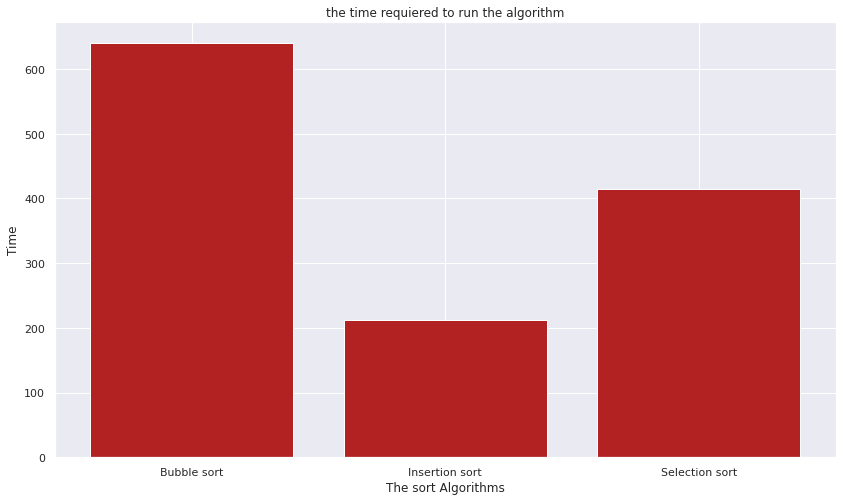

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

time_list = [time1, time2, time3]
x = np.arange(len(time_list))
fig, ax = plt.subplots(figsize=(14, 8))
plt.bar(x, time_list,color = 'firebrick')
plt.xticks(x, ('Bubble sort','Insertion sort', 'Selection sort'))
plt.title("the time requiered to run the algorithm")
ax.set_xlabel("The sort Algorithms")
ax.set_ylabel("Time")
plt.show()

4. What is the most optimal algorithm, in your opinion, and why?

The second algorithm is the optimal algorithm as these algorithm uses less time with respect to the other algorithms as we can see from the last question, and also guarantee the same results of the other algorithms.

5. Implement a sorting algorithm using MapReduce and compare it against the three algorithms previously implemented using the __ApplicantsInfo.txt__ file.

In [ ]:
def sorting4(lista):
    if len(lista) > 1:
        i = j = k = 0
        #  first we divided the array into two subarrays
        middle = len(lista)//2
        # the first array from start to middle 
        F = lista[:middle]
        # the second array from middle to end 
        S = lista[middle:]
        # sorting function for the first part of the array
        sorting4(F)
        # sorting function for the second part of the array
        sorting4(S)
        # sort the elements of the arrays by grades then alphabetically 
        while i < len(F) and j < len(S):
            if F[i][1] > S[j][1]:
                lista[k] = F[i]
                i += 1
            elif F[i][1] == S[j][1] and F[i][0] < S[j][0]:
                lista[k] = F[i]
                i += 1
            else:
                lista[k] = S[j]
                j += 1
            k += 1
        # put the remaining elements in the array
        while i < len(F):
            lista[k] = F[i]
            i += 1
            k += 1
        while j < len(S):
            lista[k] = S[j]
            j += 1
            k += 1

In [ ]:
import time
from datetime import timedelta
start_time = time.monotonic()
# open existed text file ApplicantsInfo and save the output in a new text file RankingList 
with open('/content/drive/MyDrive/ADM_HW_3/ApplicantsInfo.txt') as f1, open('/content/drive/MyDrive/ADM_HW_3/RankingList4.txt', 'a') as f2:
    # content of the file f1 as a list
    f1=list(f1)
    # empty list
    x=[]
    for line in f1[1:]:
        # take combined input name and exams grades and split values using split function
        raw = line.rstrip().split()
        # we sum the elements of each line strating from the third element (the first and second elements are name and surname)
        grades = sum(int(i) for i in raw[2:])
        # average of the grades
        average = grades/len(raw[2:])
        # we concatenate the first two element name and surname to the third element which is the average round to two only decimals
        new_data = ' '.join(raw[:2] + [str("%.2f" % average)])
        # we append the results in a list
        x.append(new_data)
    # two empty lists
    ls1 = []
    for i in x[:]:
        # take combined input name and grade and split values using split function
        x = i.rstrip().split()[0]+' '+i.rstrip().split()[1]
        y = i.rstrip().split()[2]
      # add name and grades in a list
        ls1.append((x,y))
    # sort the list and save it in the new text file 
    sorting4(ls1)  
    for i in ls1:
        # print name and marks stored 
        print(i[0]+' '+i[1],file=f2)

a = open('/content/drive/MyDrive/ADM_HW_3/RankingList4.txt','r')   
#print( list(a) )

end_time = time.monotonic()
print('The time required to run the third algorithm is ',timedelta(seconds=end_time - start_time))

The time required to run the third algorithm is  0:00:14.199889


The mapreduce algorithm has time complexity of O(nlogn), which is a significant improvement over the other algorithms. The mapreduce algorithm is fast with respect to the others as we can see it requieres only 14 seconds, while the fastest algorithm among the three first algorithms which is insertion sort algorithm requieres 3 minutes and 32 seconds to execute the code.